In [1]:
# 02_build_graph.ipynb — Cell 1
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json

# Load the cleaned dataframe produced in 01_load_and_clean.ipynb
# If you didn't save df to disk, run this in the SAME kernel/session where df already exists,



In [2]:
# ---- Load cleaned professor data ----

df = pd.read_json("../data/processed/cleaned_professors.json")

print("Data loaded successfully")
print(df.shape)
print(df.columns)
df.head(2)


Data loaded successfully
(1228, 2)
Index(['clean_text', 'professor_dict'], dtype='object')


,clean_text,professor_dict
0,has worked as a designer for the last decade i...,{'Corporate Experience - Organization': ['A&M ...
1,Mr. Madgar has been teaching economics part ti...,{'Corporate Experience - Organization': ['Bemi...


In [3]:


# ---- Build nodes & edges from professor_dict ----
G = nx.DiGraph()


In [4]:
# ---- safe edge adder (no AtlasView writes, GraphML-friendly labels) ----
RELATION_LABELS = {
    "AcademicOrg": "Studied at",
    "CorporateOrg": "Worked at",
    "CorporateLoc": "Worked in",
    "Education":   "Has degree",
    "Subject":     "Teaches/subject"
}

def add_edge(u: str, v: str, role: str):
    """Create/update an edge and keep human labels. Store strings (GraphML-safe)."""
    label = RELATION_LABELS.get(role, role)

    if G.has_edge(u, v):
        # read-modify-write directly on the edge attr dict (not via a view copy)
        roles = set(G[u][v].get("roles_set", []))
        labels = set(G[u][v].get("labels_set", []))
        roles.add(role)
        labels.add(label)
        # keep internal sets as lists, but also a string version for export
        G[u][v]["roles_set"]  = list(roles)
        G[u][v]["labels_set"] = list(labels)
        G[u][v]["roles"] = "; ".join(sorted(roles))   # string for GraphML
        G[u][v]["label"] = "; ".join(sorted(labels))  # string for GraphML
    else:
        G.add_edge(
            u, v,
            roles_set=[role],
            labels_set=[label],
            roles=role,          # string
            label=label          # string
        )



In [5]:
# ---- Nodes & labeled relations ----

# 1) Ensure professor nodes exist
for i, row in df.iterrows():
    pid = f"PROF_{i}"
    if not G.has_node(pid):
        # You can put a real professor label here if you have one; using index as fallback
        G.add_node(pid, label=f"Professor {i}", ntype="PROFESSOR")

# 2) Helpers to create entity nodes and labeled edges
def _add_entity_node(name: str, ntype: str):
    if not name: 
        return None
    nid = f"{ntype}:{name}"
    if not G.has_node(nid):
        G.add_node(nid, label=name, ntype=ntype)  # keep attributes simple (GraphML safe)
    return nid

def _rel(prof_id: str, target_label: str, target_type: str, edge_label: str):
    tgt = _add_entity_node(target_label, target_type)
    if tgt:
        # store a string 'label' so Gephi shows it on edges
        G.add_edge(prof_id, tgt, label=edge_label, rtype=edge_label)

# 3) Build edges with semantic labels
for i, row in df.iterrows():
    pid = f"PROF_{i}"
    d = row["professor_dict"]

    # Academic background
    for org in d.get("Academic Background - Organization", []):
        _rel(pid, org, "ORG", "Studied at")
    for edu in d.get("Academic Background - Education", []):
        _rel(pid, edu, "EDU", "Has degree")

    # Teaching / subjects
    for subj in d.get("Academic Experience - Subjects", []):
        _rel(pid, subj, "SUBJECT", "Teaches")

    # Corporate experience
    for org in d.get("Corporate Experience - Organization", []):
        _rel(pid, org, "ORG", "Worked at")
    for loc in d.get("Corporate Experience - Location", []):
        _rel(pid, loc, "LOC", "Worked in")


In [6]:




# ---- Quick stats ----
node_types = pd.Series(nx.get_node_attributes(G, "ntype")).value_counts()
print("Node counts by type:\n", node_types.to_string(), "\n")
print("Total nodes:", G.number_of_nodes(), "  Total edges:", G.number_of_edges())

# Top connected ORGs/LOCs
deg = dict(G.degree())
top_orgs = sorted([(n, deg[n]) for n, d in G.nodes(data=True) if d.get("ntype")=="ORG"], key=lambda x: x[1], reverse=True)[:15]
top_locs = sorted([(n, deg[n]) for n, d in G.nodes(data=True) if d.get("ntype")=="LOC"], key=lambda x: x[1], reverse=True)[:15]
print("\nTop ORGs by degree:")
for n, k in top_orgs: print(nx.get_node_attributes(G,"label")[n], "->", k)
print("\nTop LOCs by degree:")
for n, k in top_locs: print(nx.get_node_attributes(G,"label")[n], "->", k)

# ---- Save artifacts ----
os.makedirs("../outputs/graph", exist_ok=True)

# --- Minimal GraphML-safe coercion ---
def _coerce(v):
    if isinstance(v, (set, list, dict, tuple)):
        return json.dumps(v, ensure_ascii=False)
    if isinstance(v, (str, int, float, bool)) or v is None:
        return v
    return str(v)

for _, data in G.nodes(data=True):
    for k in list(data.keys()):
        data[k] = _coerce(data[k])

for _, _, data in G.edges(data=True):
    for k in list(data.keys()):
        data[k] = _coerce(data[k])



Node counts by type:
 ORG          5476
SUBJECT      1421
PROFESSOR    1228
LOC           789
EDU           334 

Total nodes: 9248   Total edges: 14191

Top ORGs by degree:
Academic Ba -> 83
Academic Bac -> 78
Universidad Complutense de Madrid -> 72
Universidad Autónoma De Madrid -> 52
Universidad Pontificia Comillas -> 48
Universidad Politécnica De Madrid -> 43
Harvard University -> 38
IESE Business School -> 33
Universidad Complutense -> 32
Universidad Autónoma de Madrid -> 27
Harvard Business School -> 24
Universidad Pontificia De Comillas -> 23
Climate Action -> 23
Complutense University Of Madrid -> 22
University Of Oxford -> 18

Top LOCs by degree:
Spain -> 484
Madrid -> 148
United States -> 90
London -> 51
Portugal -> 42
Germany -> 39
France -> 38
New York -> 34
Italy -> 30
Switzerland -> 30
Europe -> 28
United Kingdom -> 23
Mexico -> 20
Barcelona -> 19
Paris -> 19


In [7]:
import json

def _to_graphml_safe(v):
    if isinstance(v, set):
        return "; ".join(sorted(map(str, v)))
    if isinstance(v, list):
        return "; ".join(map(str, v))
    if isinstance(v, dict):
        return json.dumps(v, ensure_ascii=False)
    return v


In [8]:

# GraphML (good for Gephi)
nx.write_graphml(G, "../outputs/graph/prof_kg.graphml")


In [9]:
# Also export GEXF (Gephi) and CSVs
nx.write_gexf(G, "../outputs/graph/prof_kg.gexf")

nodes_df = pd.DataFrame(
    [(n, d.get("label"), d.get("ntype")) for n, d in G.nodes(data=True)],
    columns=["node_id","label","type"]
)
edges_df = pd.DataFrame(
    [(u, v, d.get("label")) for u, v, d in G.edges(data=True)],
    columns=["source","target","relation"]
)
nodes_df.to_csv("../outputs/graph/nodes.csv", index=False)
edges_df.to_csv("../outputs/graph/edges.csv", index=False)



Saved:
 - ../outputs/graph/prof_kg.graphml
 - ../outputs/graph/nodes.csv
 - ../outputs/graph/edges.csv


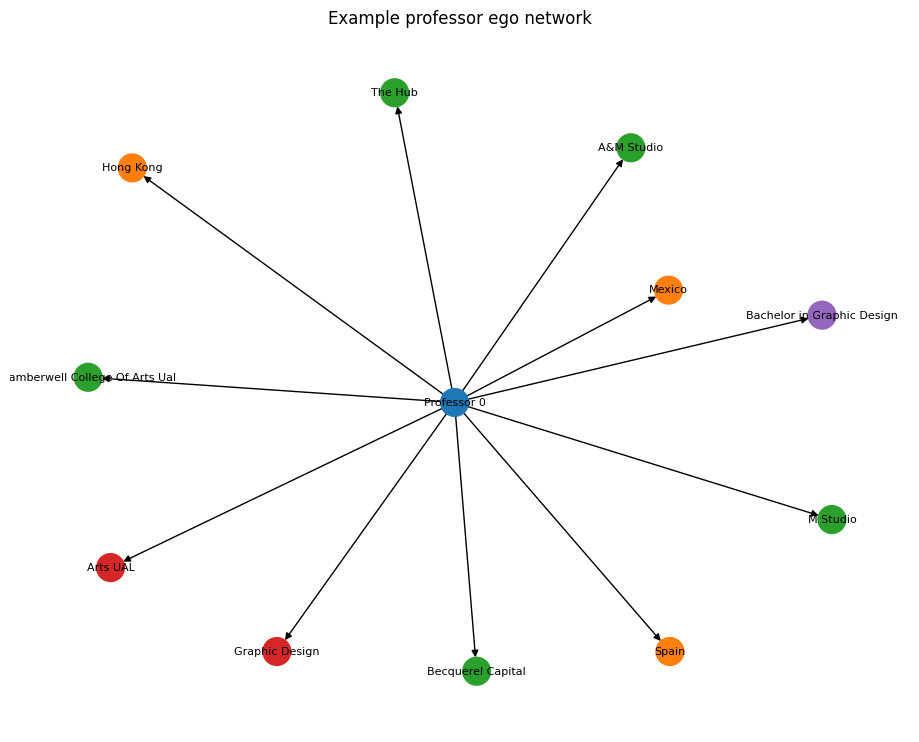

In [10]:


# Node/edge tables for your report
nodes_df = pd.DataFrame([(n, d.get("label"), d.get("ntype")) for n, d in G.nodes(data=True)],
                        columns=["node_id","label","type"])
edges_df = pd.DataFrame([(u, v, sorted(list(attr.get("roles", set())))) for u, v, attr in G.edges(data=True)],
                        columns=["source","target","roles"])

nodes_df.to_csv("../outputs/graph/nodes.csv", index=False)
edges_df.to_csv("../outputs/graph/edges.csv", index=False)

print("\nSaved:")
print(" - ../outputs/graph/prof_kg.graphml")
print(" - ../outputs/graph/nodes.csv")
print(" - ../outputs/graph/edges.csv")

# ---- (Optional) Tiny visualization: pick one professor ego network ----
try:
    sample_prof = next(n for n, d in G.nodes(data=True) if d.get("ntype")=="PROFESSOR")
    ego = nx.ego_graph(G, sample_prof, radius=1)
    plt.figure(figsize=(9,7))
    pos = nx.spring_layout(ego, seed=42)
    colors = []
    for n in ego.nodes():
        t = G.nodes[n].get("ntype")
        colors.append({"PROFESSOR": "tab:blue", "ORG":"tab:green", "LOC":"tab:orange", "EDU":"tab:purple", "SUBJECT":"tab:red"}.get(t, "tab:gray"))
    nx.draw(ego, pos, with_labels=True,
            labels=nx.get_node_attributes(ego, "label"),
            node_color=colors, node_size=400, font_size=8)
    plt.title("Example professor ego network")
    plt.show()
except StopIteration:
    print("No professor nodes to visualize.")


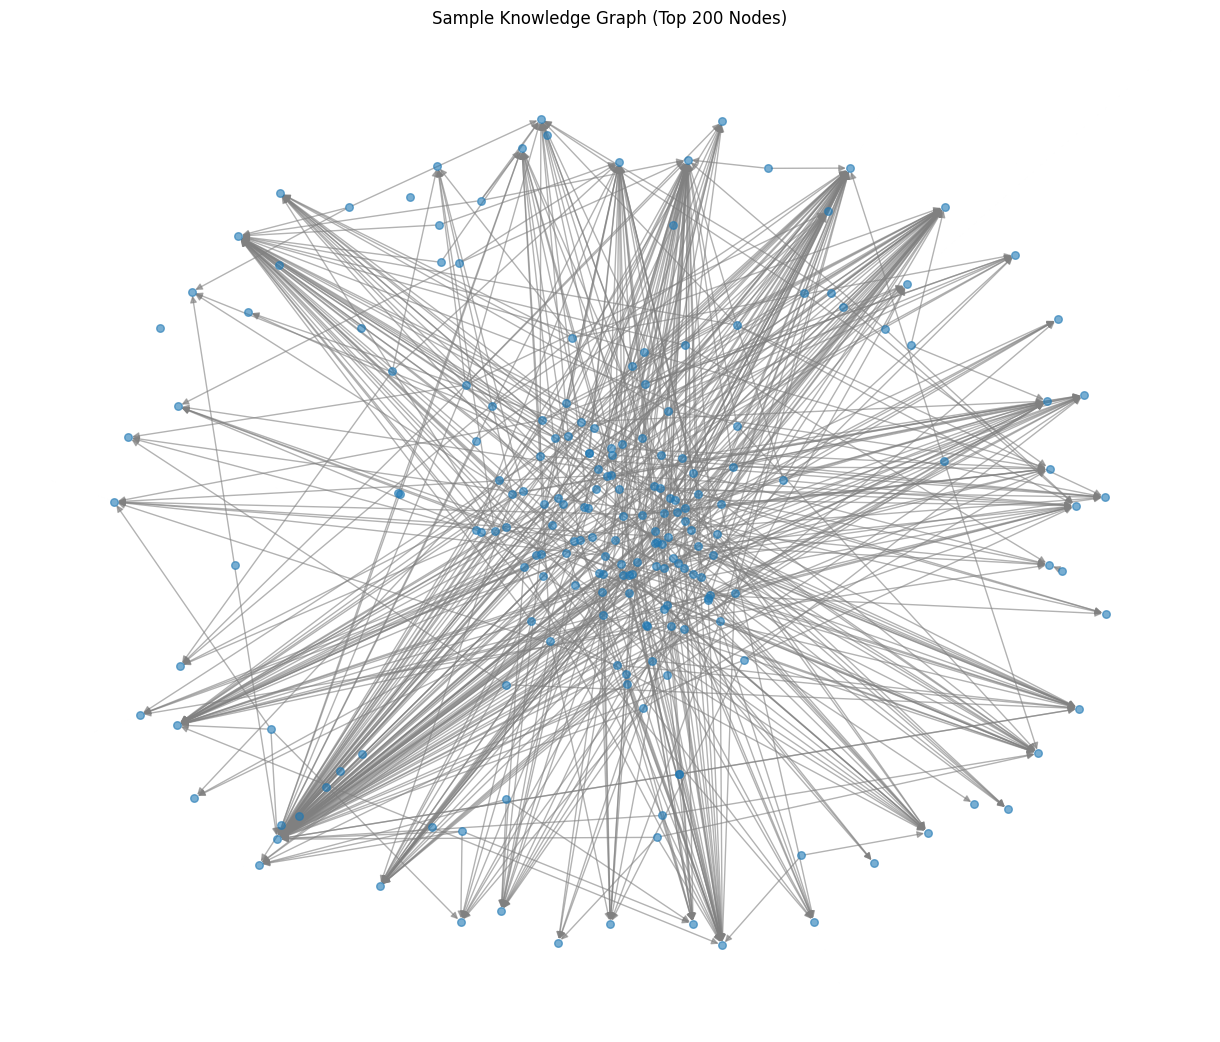

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# pick a manageable subset (e.g., top 200 most connected nodes)
sub_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:200]
H = G.subgraph([n for n, _ in sub_nodes])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, seed=42)
nx.draw(
    H,
    pos,
    with_labels=False,
    node_size=30,
    edge_color="gray",
    alpha=0.6,
)
plt.title("Sample Knowledge Graph (Top 200 Nodes)")
plt.show()


In [12]:
import os
import networkx as nx

# ---- Export a smaller sample subgraph for Gephi ----
# Select the top 300 most connected nodes for a lighter graph
sub_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
H = G.subgraph([n for n, _ in sub_nodes])

os.makedirs("../outputs/graph", exist_ok=True)
sample_path = "../outputs/graph/prof_kg_sample.graphml"

# Sanitize node/edge attributes (GraphML safe)
for n, data in H.nodes(data=True):
    for k, v in data.items():
        if isinstance(v, (set, list, dict)):
            data[k] = str(v)
for u, v, data in H.edges(data=True):
    for k, v2 in data.items():
        if isinstance(v2, (set, list, dict)):
            data[k] = str(v2)

# Save for Gephi
nx.write_graphml(H, sample_path)
print(f"Sample graph saved to: {sample_path}")
print(f"Nodes: {H.number_of_nodes()}  Edges: {H.number_of_edges()}")


Sample graph saved to: ../outputs/graph/prof_kg_sample.graphml
Nodes: 50  Edges: 96
